# Final Plotting

In [1]:
from plotting_utils import (
    plot_forecast,
    plot_crps_bydate,
    score_improvement_bysite,
    plot_improvement_bysite,
    plot_global_percentages,
    plot_region_percentages,
    plot_site_type_percentages_bymodel,
    plot_site_type_percentages_global,
    plot_window_and_sitetype_performance,
    generate_metadata_df,
    plot_crps_over_time_agg,
)
import pandas as pd
from utils import (
    establish_s3_connection,
    NaiveEnsembleForecaster
)
import warnings
import os

# Ignore all warnings; admittedly not the best practice here :/
warnings.filterwarnings("ignore")

targets = pd.read_csv("targets.csv.gz")
metadata = generate_metadata_df()

/home/rstudio/.virtualenv/neon4cast-darts/lib/python3.10/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/rstudio/.virtualenv/neon4cast-darts/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


Making a connection to the S3 Bucket, note that this is not mandatory. Otherwise, files should save locally.

In [2]:
s3_client = establish_s3_connection(
    endpoint='https://minio.carlboettiger.info',
    json_file='credentials.json',
) 


 Using https://minio.carlboettiger.info for data storage and access.


Now, we collect all the forecasts and conglomerate into dataframes for plotting

In [3]:
model_names = ["BlockRNN", "Transformer", "NBEATS", "TCN", "RNN", "TFT", "NLinear", "DLinear"]
target_variables = ["oxygen", "temperature", "chla"]
ids = [0, 1, 2, 3, 4]
s3_dict = {'client': s3_client, 'bucket': 'shared-neon4cast-darts'}
scores_dict = {}
for model in model_names:
    scores_dict[model] = {}
    for id_ in ids:
        if model == "NLinear" or model == "DLinear":
            if id_ > 1:
                continue
        scores_dict[model][id_] = {}
        for target_variable in target_variables:
            inter_merged, intra_merged = score_improvement_bysite(
                model,
                id_,
                targets, 
                target_variable, 
                s3_dict=s3_dict,
            )
            scores_dict[model][id_][target_variable] = {}
            scores_dict[model][id_][target_variable]['inter'] = inter_merged
            scores_dict[model][id_][target_variable]['intra'] = intra_merged

In [4]:
global_dfs = {}
for target_variable in target_variables:
    global_dfs[target_variable] = {}
    for pos in ['inter', 'intra']:
        concat_list = []
        for model in model_names:
            for id_ in ids:
                if model == "DLinear" or model == "NLinear":
                    if id_ > 1:
                        continue
                concat_list.append(scores_dict[model][id_][target_variable][pos])
        global_dfs[target_variable][pos] = pd.concat(concat_list)

Now, we will find the best models of those trained (note that we trained multiple models of each algorithm).

In [7]:
def return_best_id(df):
    medians = df.groupby('model_id')['skill_historical_ml_crps'].median()
    # Be Careful here, using max with skill score, min with difference
    best_median_id = medians.idxmax()

    return best_median_id

In [8]:
best_models = {}
for model in model_names:
    best_models[model] = {}
    for target_variable in target_variables:
        # Need to do the following but also filter for model type
        df_ = global_dfs[target_variable]['inter']
        df = df_[df_['model'] == model]
        best_models[model][target_variable] = return_best_id(df)

In [9]:
best_performers_dfs = {}
for target_variable in target_variables:
    best_performers_dfs[target_variable] = {}
    for pos in ['inter', 'intra']:
        best_performers_dfs[target_variable][pos] = {}
        best_performers_dfs[target_variable][pos] = pd.concat(
            [scores_dict[model][best_models[model][target_variable]]
             [target_variable][pos] for model in model_names]
        )

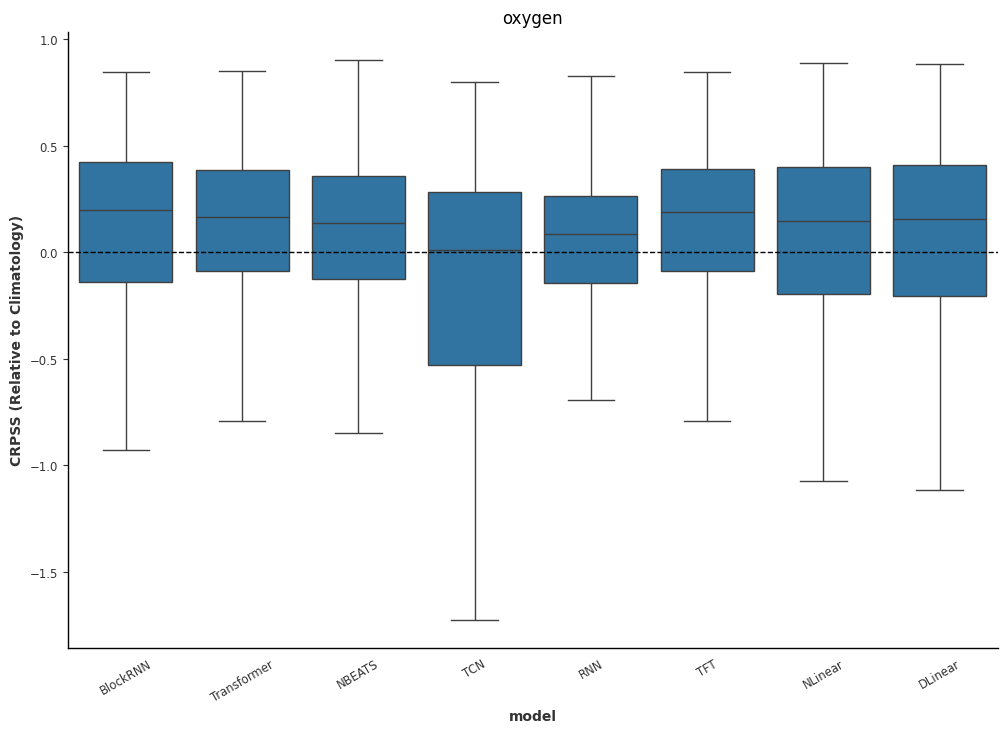

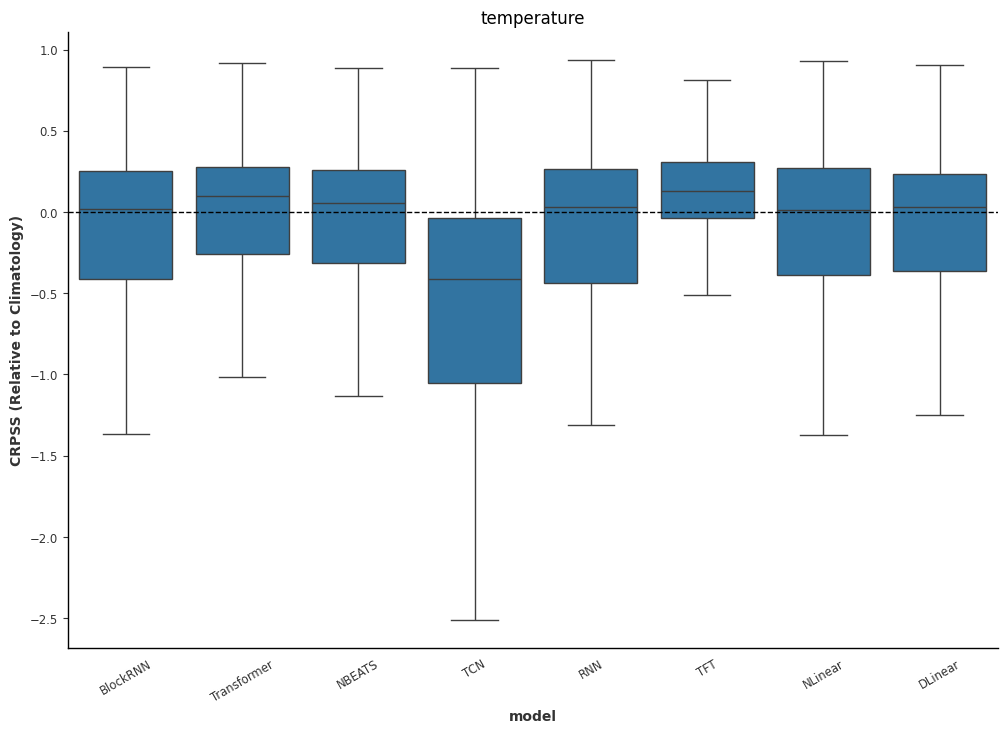

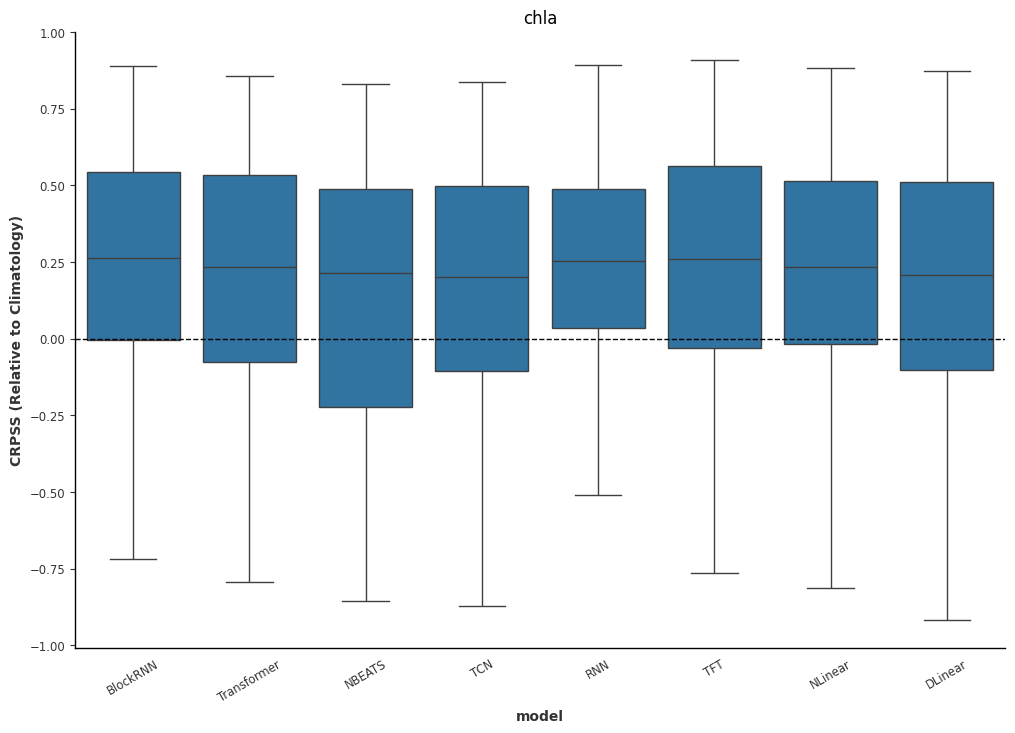

In [10]:
for target_variable in target_variables:
    plot_global_percentages(best_performers_dfs[target_variable]['inter'], target_variable)

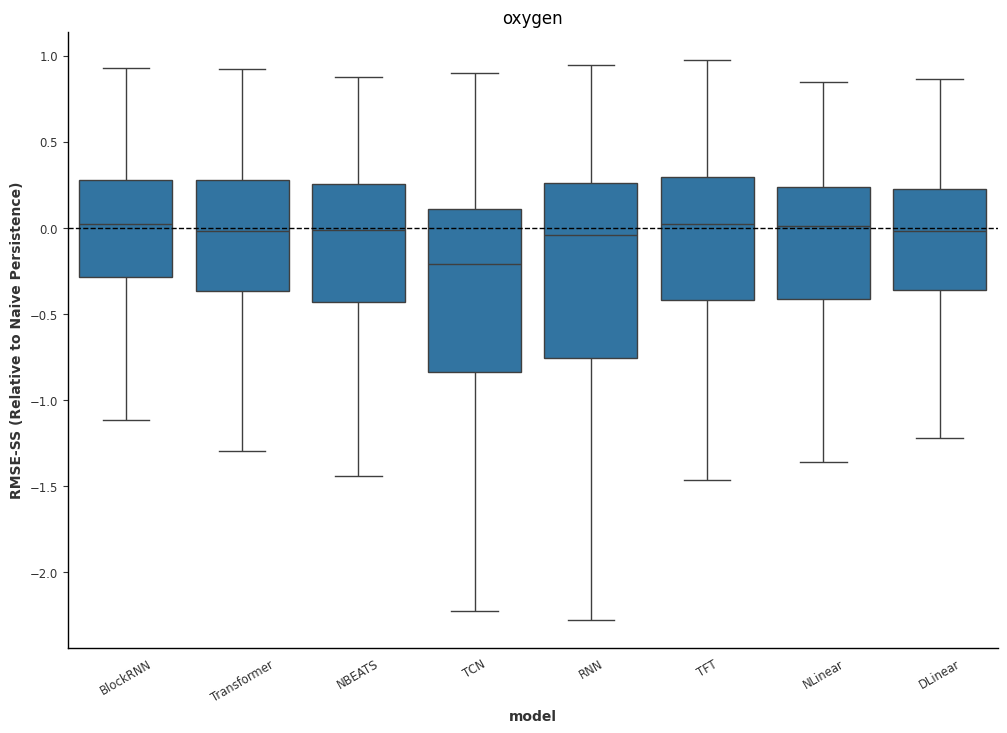

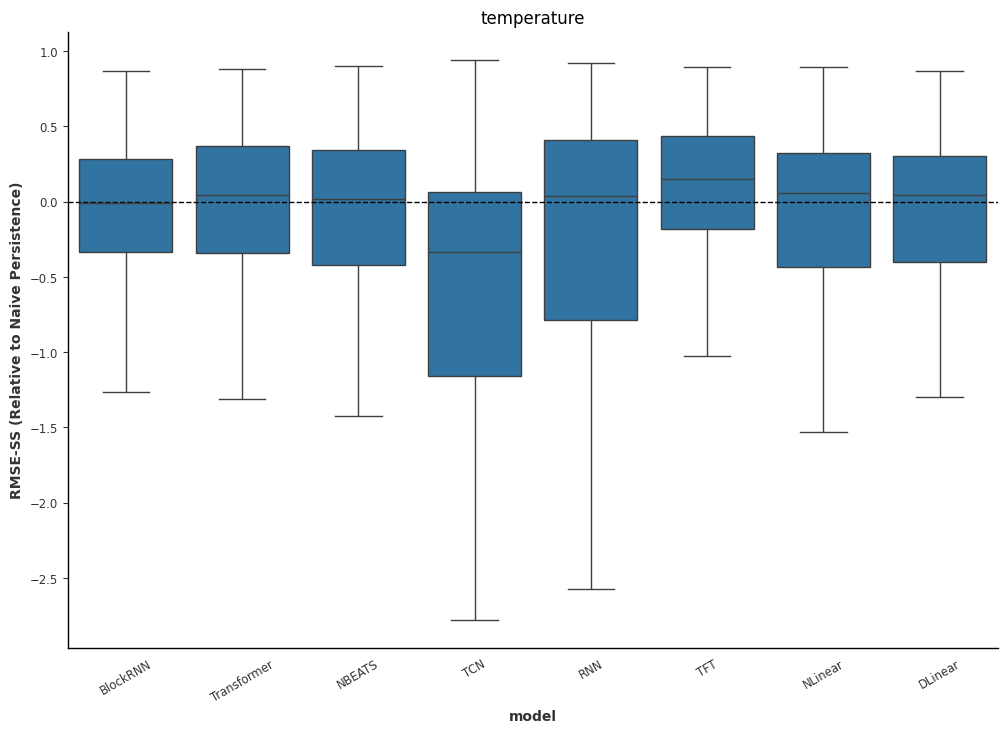

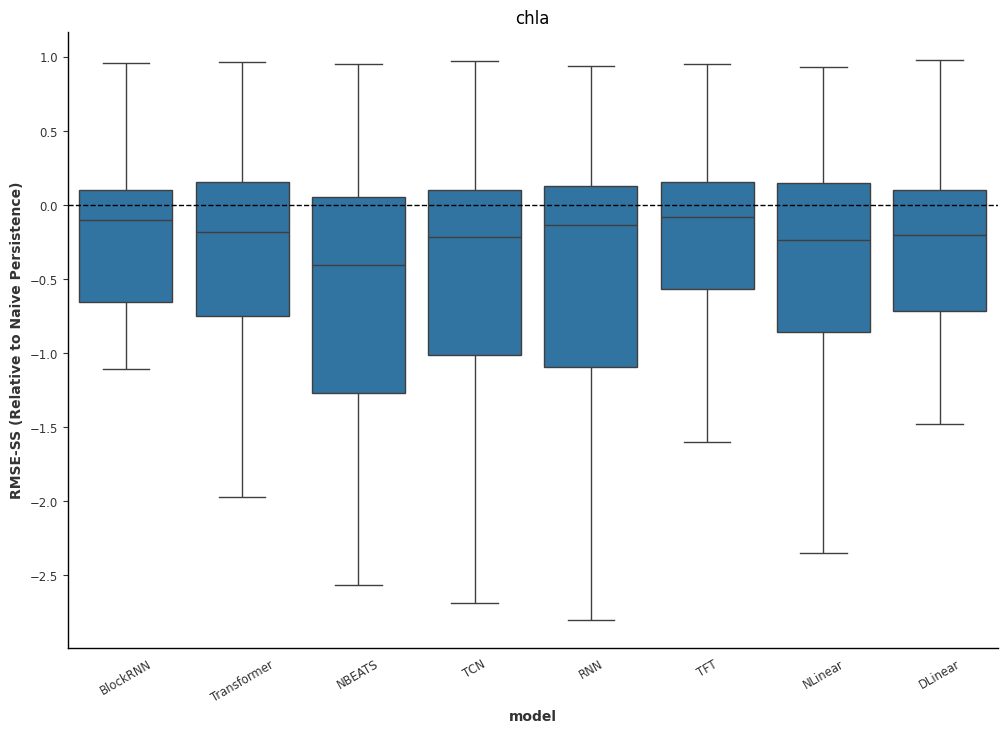

In [11]:
for target_variable in target_variables:
    plot_global_percentages(best_performers_dfs[target_variable]['inter'], target_variable, historical=False)

Record the best performing models for later use

In [12]:
# Don't need to run this cell if the dataframes have been loaded
best_models_listform = {}
for target_variable in target_variables:
    best_models_listform[target_variable] = [[model, best_models[model][target_variable]] for model in model_names]

Save the dataframes used for plotting

In [13]:
if not os.path.exists('dataframes/'):
    os.makedirs('dataframes/')
    
for target_variable in target_variables:
    for pos in ['inter', 'intra']:
        best_performers_dfs[target_variable][pos].to_csv(f'dataframes/{target_variable}_{pos}.csv', index=False)

Load the scoring dataframes.

In [14]:
best_performers_dfs = {}
best_models_listform = {}
for target_variable in target_variables:
    best_performers_dfs[target_variable] = {}
    for pos in ['inter', 'intra']:
        best_performers_dfs[target_variable][pos] = pd.read_csv(f'dataframes/{target_variable}_{pos}.csv')
        if pos == 'inter':
            df = best_performers_dfs[target_variable][pos]
            best_models_listform[target_variable] = [[model, int(df[df['model'] == model]['model_id'].unique())] for model in model_names]

Now, putting together a Naive Ensemble model of the machine learning forecasts.

In [15]:
# Need to get all the dates used in the different forecasts
site_date_dict = {}
for target_variable in target_variables:
    site_date_dict[target_variable] = best_performers_dfs[target_variable]['inter'].groupby('site_id')['date'].unique().apply(list).to_dict()

Now making forecasts with the ensemble model

In [16]:
for target_variable in target_variables:
    sites_w_forecasts = site_date_dict[target_variable].keys()
    for site in sites_w_forecasts:
        forecasted_dates = site_date_dict[target_variable][site]
        for date in forecasted_dates:
            ensemble_model = NaiveEnsembleForecaster(
                model_list=best_models_listform[target_variable],
                site_id=site,
                target_variable=target_variable,
                output_name='model_0',
                date=date,
                s3_dict=s3_dict,
            )
            ensemble_model.make_forecasts()

Now, reading those forecasts back into dataframes

In [17]:
model_names = ["NaiveEnsemble"]
ids = [0]
scores_dict = {}
for model in model_names:
    scores_dict[model] = {}
    for id_ in ids:
        scores_dict[model][id_] = {}
        for target_variable in target_variables:
            inter_merged, intra_merged = score_improvement_bysite(
                model,
                id_,
                targets, 
                target_variable, 
                s3_dict=s3_dict,
            )
            scores_dict[model][id_][target_variable] = {}
            scores_dict[model][id_][target_variable]['inter'] = inter_merged
            scores_dict[model][id_][target_variable]['intra'] = intra_merged

And concatanating to previous dataframe with best performing models

In [18]:
for target_variable in target_variables:
    best_performers_dfs[target_variable]['inter'] = pd.concat(
        [
            scores_dict['NaiveEnsemble'][0][target_variable]['inter'], 
            best_performers_dfs[target_variable]['inter']
        ], 
        ignore_index=True,
    )
    best_performers_dfs[target_variable]['intra'] = pd.concat(
        [
            scores_dict['NaiveEnsemble'][0][target_variable]['intra'], 
            best_performers_dfs[target_variable]['intra']
        ], 
        ignore_index=True,
    )

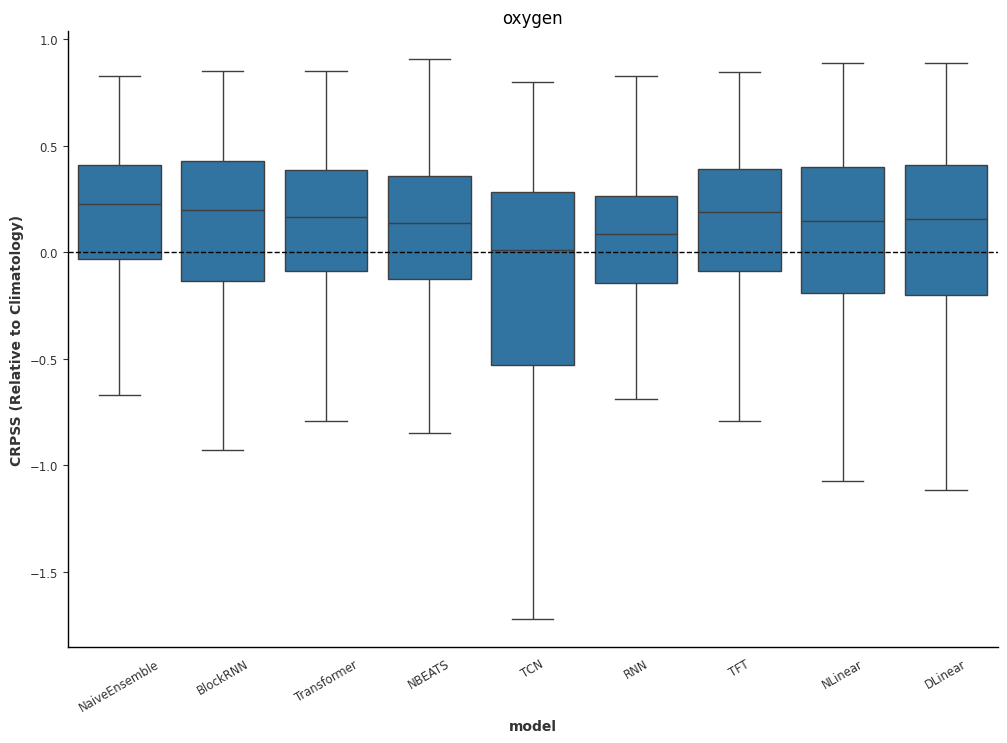

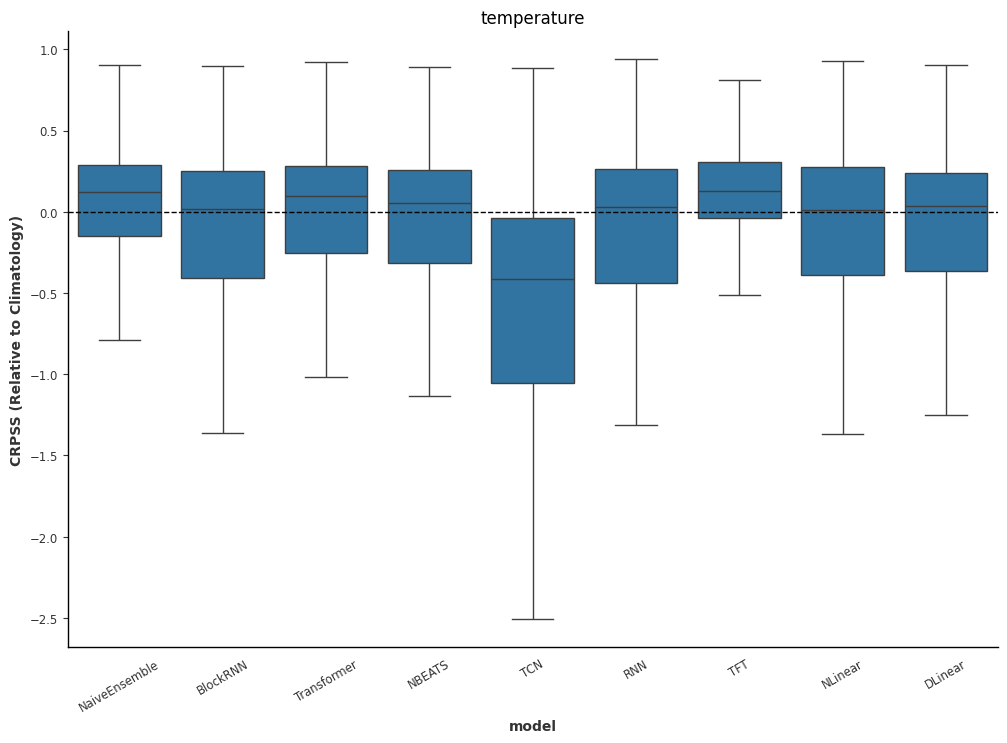

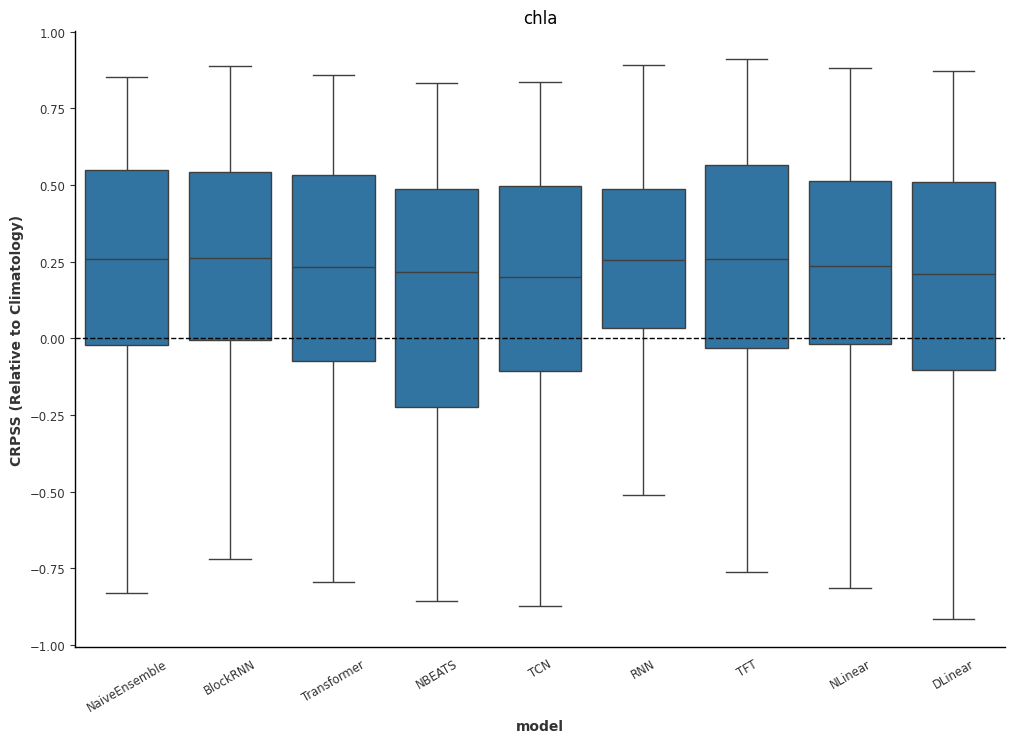

In [19]:
for target_variable in target_variables:
    plot_global_percentages(best_performers_dfs[target_variable]['inter'], target_variable)

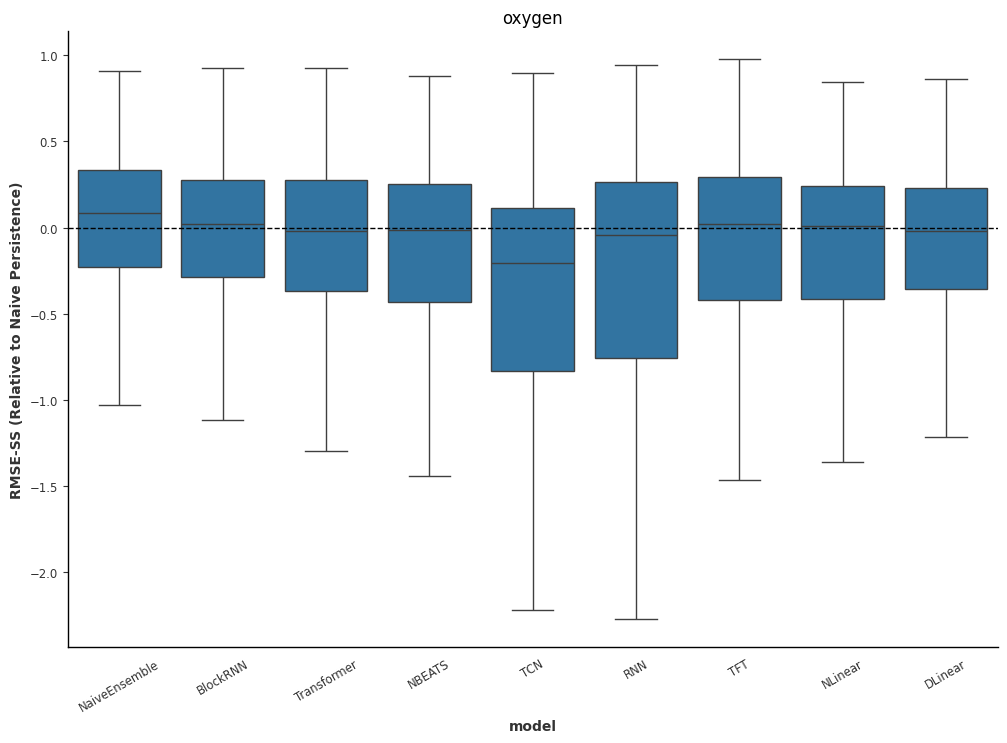

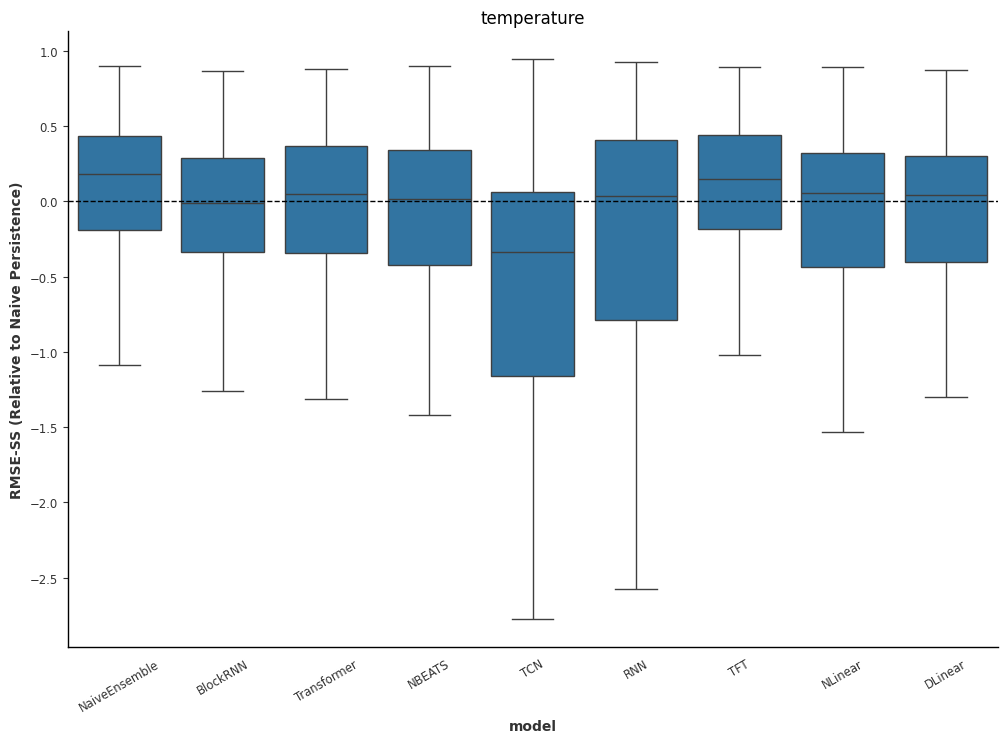

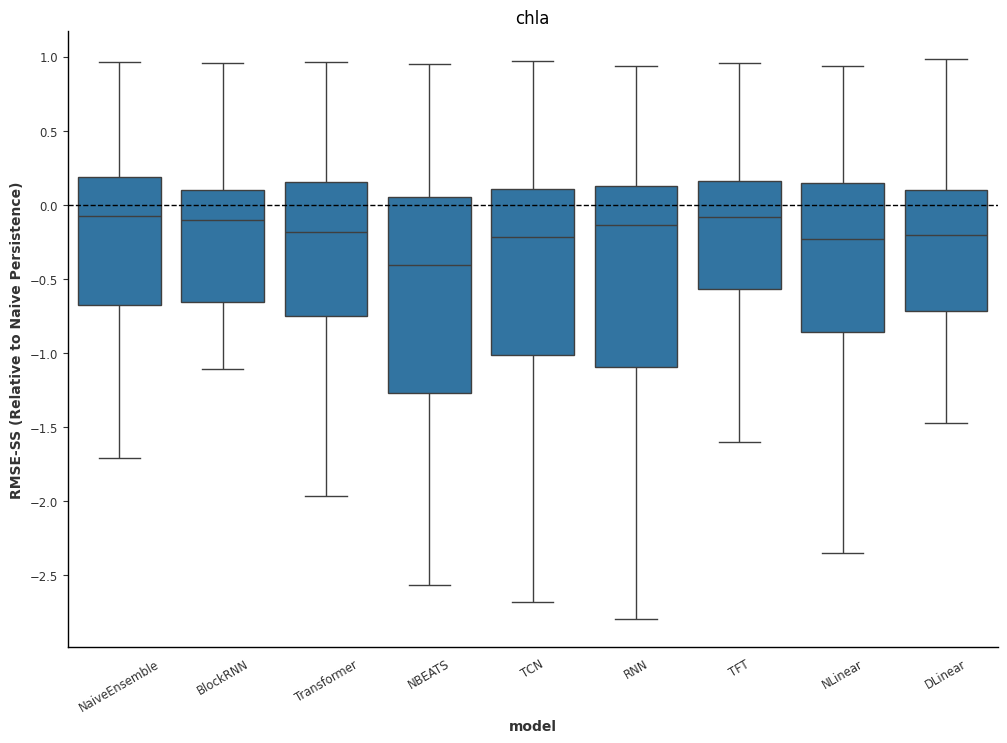

In [20]:
for target_variable in target_variables:
    plot_global_percentages(best_performers_dfs[target_variable]['inter'], target_variable, historical=False)

Saving these dataframes.

In [21]:
if not os.path.exists('dataframes/'):
    os.makedirs('dataframes/')
    
for target_variable in target_variables:
    for pos in ['inter', 'intra']:
        best_performers_dfs[target_variable][pos].to_csv(f'dataframes/{target_variable}_{pos}_all.csv', index=False)